In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import Locator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import os

def find_nearest_idx(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx - 1]) < math.fabs(value - array[idx])):
        return idx - 1
    else:
        return idx
    
def find_nearest(array, value):
    idx = find_nearest_idx(array, value)
    return array[idx]


# needed for correctly display tics for symlog scale
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """

    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]  # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (
                dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0] * 10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0] - self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (
                dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1] * 10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1] + self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i - 1]
            if abs(majorlocs[i - 1] + majorstep / 2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i - 1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

def plot_data(D, times, wavelengths, symlog=False, title='Transient absorption data', t_unit='$ns$', 
              z_unit='$\Delta A$ (mOD)', cmap='inferno_r', zmin=None, zmax=None,
              w0=None, w1=None, t0=None, t1=None, fig_size=(6, 4), dpi=500, filepath=None, transparent=True):

    if D is None or times is None or wavelengths is None:
        raise ValueError("Data cannot be None!")
        
    plt.rcParams['figure.figsize'] = fig_size
    # plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.23, hspace=0.26)

    plt.tight_layout()

    # cut data if necessary

    t_idx_start = find_nearest_idx(times, t0) if t0 is not None else 0
    t_idx_end = find_nearest_idx(times, t1) + 1 if t1 is not None else D.shape[0]

    wl_idx_start = find_nearest_idx(wavelengths, w0) if w0 is not None else 0
    wl_idx_end = find_nearest_idx(wavelengths, w1) + 1 if w1 is not None else D.shape[1]

    # crop the data if necessary
    D = D[t_idx_start:t_idx_end, wl_idx_start:wl_idx_end]
    times = times[t_idx_start:t_idx_end]
    wavelengths = wavelengths[wl_idx_start:wl_idx_end]
    
    zmin = np.min(D) if zmin is None else zmin
    zmax = np.max(D) if zmax is None else zmax
    
    diff = zmax - zmin
    w = np.abs(zmin / diff)  # white color point set to zero z value
    
    _cdict = {'red': ((0.0, 0.0, 0.0),
                   (w/2, 0.0, 0.0),
                   (w, 1.0, 1.0),
                   (w+(1-w)/3, 1.0, 1.0),
                   (w+(1-w)*2/3, 1.0, 1.0),
                   (1.0, 0.3, 0.3)),

            'green': ((0.0, 0, 0),
                   (w/2, 0.0, 0.0),
                   (w, 1.0, 1.0),
                   (w+(1-w)/3, 1.0, 1.0),
                   (w+(1-w)*2/3, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

            'blue':  ((0.0, 0.3, 0.3),
                   (w/2, 1.0, 1.0),
                   (w, 1.0, 1.0),
                   (w+(1-w)/3, 0.0, 0.0),
                   (w+(1-w)*2/3, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
            }

    custom_cmap = LinearSegmentedColormap('diverging', _cdict)
    cm.register_cmap('diverging', custom_cmap)

    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image

    # plot data matrix D

    plt.pcolormesh(x, y, D, cmap=cmap, vmin=zmin, vmax=zmax)

    plt.colorbar(label=z_unit)
    plt.title(title)
    plt.ylabel(f'$\leftarrow$ Time delay ({t_unit})')
    plt.xlabel(r'Wavelength ($nm$) $\rightarrow$')

    plt.gca().invert_yaxis()

    if symlog:
        plt.yscale('symlog', subsy=[1, 2, 3, 4, 5, 6, 7, 8, 9], linscaley=0.5, linthreshy=10)
        yaxis = plt.gca().yaxis
        yaxis.set_minor_locator(MinorSymLogLocator(100))

    # save to file
    if filepath:
        ext = os.path.splitext(filepath)[1].lower()[1:]
        plt.savefig(fname=filepath, format=ext, transparent=transparent, dpi=dpi)
        
    plt.show()

# Plotting

In [2]:
### ! CHANGE THE FILENAME OF YOUR DATA HERE !
fname = '2019_03_19_FLA_NF_MeOH_20ps_3.cut_aver_SPECFIT.txt'

fname_no_ext = os.path.splitext(fname)[0].lower()
data = np.loadtxt(fname, delimiter='\t', skiprows=3, dtype=np.float64)
times = data[0, 1:]
wavelengths = data[1:, 0]
D = data[1:, 1:].T  # also, transpose the data, so that rows contains spectra and columns traces

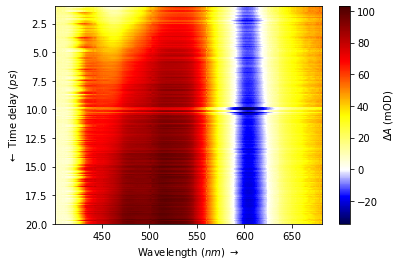

In [3]:
filepath = fname_no_ext + '.png'

plot_data(D*1e3, times*1e12, wavelengths, symlog=False, t0=1, t1=None, w0=400, fig_size=(6, 4),
          cmap='diverging', t_unit='$ps$', title='', filepath=None, dpi=500)
